In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

random.seed(1337)

In [ ]:
import kagglehub

path = kagglehub.dataset_download("joebeachcapital/30000-spotify-songs")

print("Path to dataset files:", path)

In [ ]:
### Preprocess Data and Define Summary Statistics
# Mean 120 tempo is a common default in many genres, interesting

# Load
spotify_df = pd.read_csv(f"spotify_songs.csv")

# Remove duplicates
spotify_df = spotify_df.drop_duplicates('track_id').reset_index(drop = True)

# Summary Statistics
print("=== SPOTIFY DATASET SUMMARY ===")
print(f"Total number of songs: {spotify_df.shape[0]:,}")
print(f"Total number of features: {spotify_df.shape[1]}")
print(f"Number of unique tracks: {spotify_df['track_id'].nunique():,}")
print(f"Number of unique artists: {spotify_df['track_artist'].nunique():,}")
print(f"Number of genres: {spotify_df['playlist_genre'].nunique()}")
print(f"Number of subgenres: {spotify_df['playlist_subgenre'].nunique()}")

print("\n=== GENRE DISTRIBUTION ===")
genre_counts = spotify_df['playlist_genre'].value_counts()
for genre, count in genre_counts.items():
    print(f"{genre.title()}: {count:,} songs ({count/len(spotify_df) * 100:.1f}%)")

print("\n=== AUDIO FEATURE STATISTICS ===")
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
feature_stats = spotify_df[audio_features].describe()
print(feature_stats.round(3))

print(f"\n=== DATA QUALITY ===")
print(f"Missing values: {spotify_df.isnull().sum().sum()}")
print(f"Duplicate tracks removed: {pd.read_csv('spotify_songs.csv').shape[0] - spotify_df.shape[0]:,}")

=== SPOTIFY DATASET SUMMARY ===
Total number of songs: 28,356
Total number of features: 23
Number of unique tracks: 28,356
Number of unique artists: 10,692
Number of genres: 6
Number of subgenres: 24

=== GENRE DISTRIBUTION ===
Rap: 5,401 songs (19.0%)
Pop: 5,132 songs (18.1%)
Edm: 4,877 songs (17.2%)
R&B: 4,504 songs (15.9%)
Rock: 4,305 songs (15.2%)
Latin: 4,137 songs (14.6%)

=== AUDIO FEATURE STATISTICS ===
       danceability     energy   loudness  speechiness  acousticness  \
count     28356.000  28356.000  28356.000    28356.000     28356.000   
mean          0.653      0.698     -6.818        0.108         0.177   
std           0.146      0.184      3.036        0.103         0.223   
min           0.000      0.000    -46.448        0.000         0.000   
25%           0.561      0.579     -8.309        0.041         0.014   
50%           0.670      0.722     -6.261        0.063         0.080   
75%           0.760      0.843     -4.709        0.133         0.260   
max      

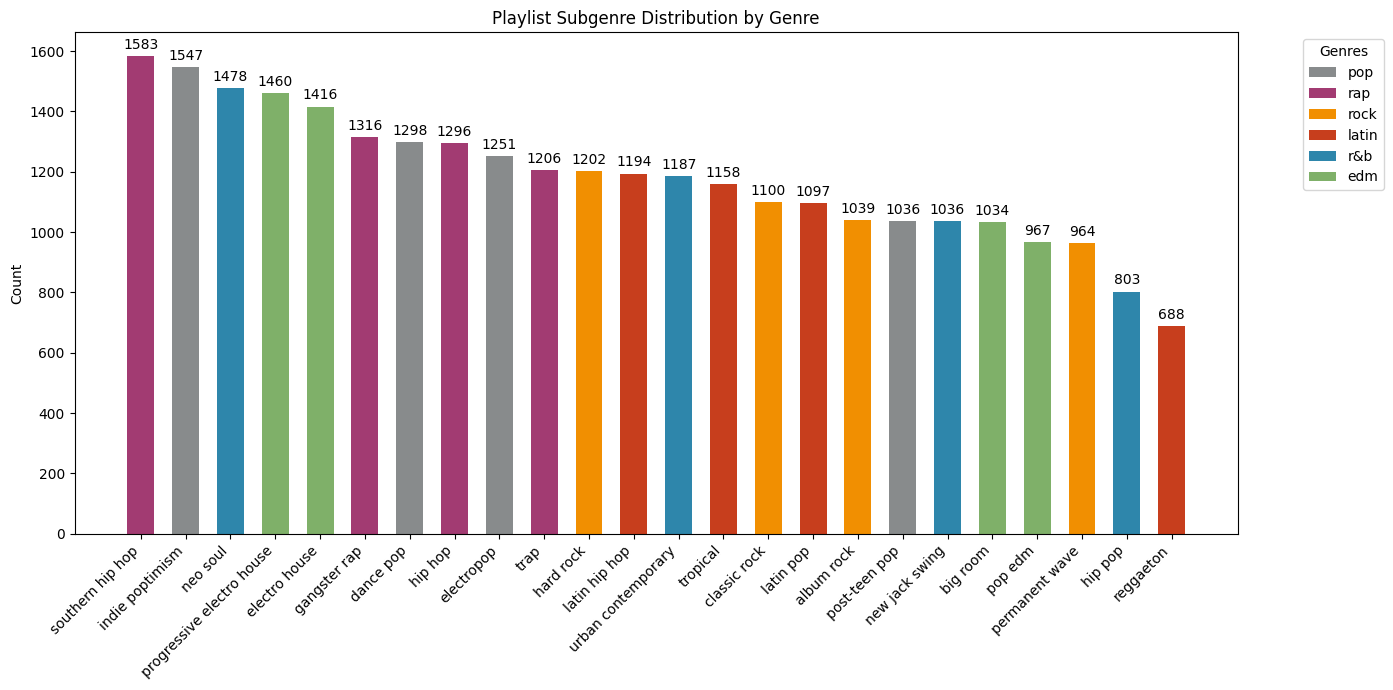

In [ ]:
### Visualize the Distribution of Playlist Genres and Subgenres

subgenres = spotify_df[['playlist_genre', 'playlist_subgenre']]
occurences = spotify_df['playlist_subgenre'].value_counts(ascending = False)

# Create a mapping
subgenre_to_genre = spotify_df.groupby('playlist_subgenre')['playlist_genre'].first()

# Create color mapping
unique_genres = spotify_df['playlist_genre'].unique()

custom_colors = ["#888B8C", '#A23B72', '#F18F01', '#C73E1D', '#2E86AB', '#7FB069']
if len(unique_genres) > len(custom_colors):
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_genres)))
else:
    colors = custom_colors[:len(unique_genres)]

genre_color_map = dict(zip(unique_genres, colors))

# Map colors to subgenres off of genre
bar_colors = [genre_color_map[subgenre_to_genre[subgenre]] for subgenre in occurences.index]

x = np.arange(len(occurences))  
width = 0.6  # Bar width

fig, ax = plt.subplots(layout = 'constrained', figsize = (14, 7))

# Bar chart
rects = ax.bar(x, occurences.values, width, color = bar_colors)
ax.bar_label(rects, padding = 3)
ax.set_ylabel('Count')
ax.set_title('Playlist Subgenre Distribution by Genre')
ax.set_xticks(x)
ax.set_xticklabels(occurences.index, rotation = 45, ha = 'right')
legend_elements = [plt.Rectangle((0,0),1,1, facecolor = genre_color_map[genre], label = genre) 
                   for genre in unique_genres]
ax.legend(handles = legend_elements, title = "Genres", bbox_to_anchor = (1.05, 1), loc = 'upper left')

plt.tight_layout()
plt.show()

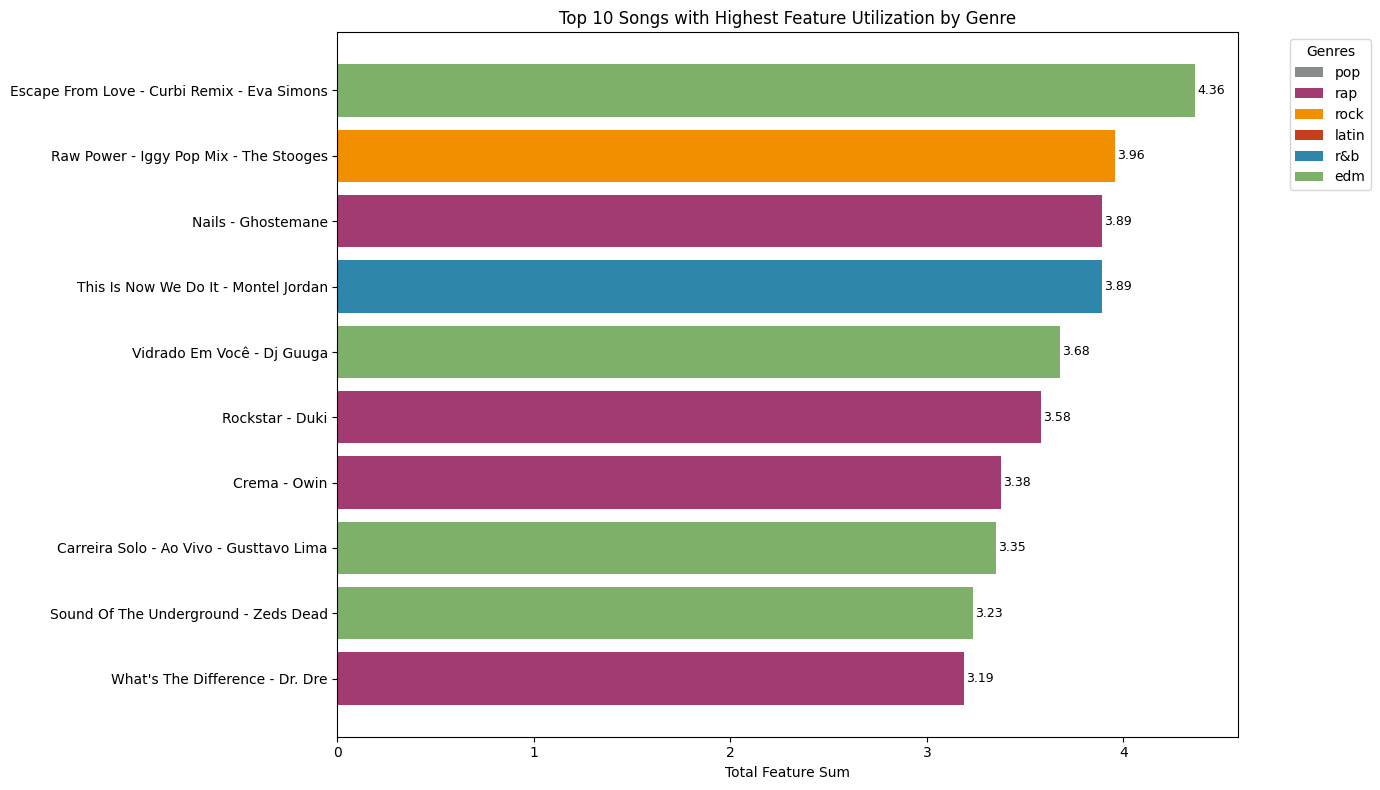

In [ ]:
### Visualizing songs that best make use of all features
# Pop doesn't do well...

subset = spotify_df[['track_id', 'track_name', 'track_artist', 'playlist_genre', 'danceability', 'energy', 'loudness', 'speechiness', 
                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

# Put tempo in the same range as other features
scaler_tempo = MinMaxScaler()
subset['tempo'] = scaler_tempo.fit_transform(subset[['tempo']])

# Feature sum by track id
variables = ['danceability', 'energy', 'loudness', 'speechiness', 
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
subset['total_sum'] = subset[variables].sum(axis = 1)

# Get top 10 songs
top_10 = subset.nlargest(10, 'total_sum')[['track_name', 'track_artist', 'playlist_genre', 'total_sum']]

# Create labels
top_10['label'] = top_10['track_name'] + ' - ' + top_10['track_artist']

# Create color mapping for genres
unique_genres = unique_genres = spotify_df['playlist_genre'].unique() # Using this DF to keep consistent genre colors
custom_colors = ["#888B8C", '#A23B72', '#F18F01', '#C73E1D', '#2E86AB', '#7FB069']
if len(unique_genres) > len(custom_colors):
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_genres)))
else:
    colors = custom_colors[:len(unique_genres)]

genre_color_map = dict(zip(unique_genres, colors))
bar_colors = [genre_color_map[genre] for genre in top_10['playlist_genre']]

# Create horizontal bar chart
fig, ax = plt.subplots(figsize = (14, 8))
bars = ax.barh(range(len(top_10)), top_10['total_sum'], color = bar_colors)
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['label'], fontsize = 10)
ax.set_xlabel('Total Feature Sum')
ax.set_title('Top 10 Songs with Highest Feature Utilization by Genre')

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{width:.2f}', ha = 'left', va = 'center', fontsize = 9)

legend_elements = [plt.Rectangle((0,0),1,1, facecolor = genre_color_map[genre], label = genre) 
                   for genre in unique_genres]
ax.legend(handles = legend_elements, title = "Genres", bbox_to_anchor = (1.05, 1), loc = 'upper left')

ax.invert_yaxis()

features_text = "Features used: danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo"
plt.figtext(0.5, 0.02, features_text, ha = 'center', fontsize = 9, style = 'italic')

plt.tight_layout()
plt.show()

In [ ]:
### Artist Collaboration Network
# Create a network where nodes are artists and edges connect artists who appear in the same genre

# Get artist-genre relationships
artist_genre = spotify_df.groupby('track_artist')['playlist_genre'].apply(list).reset_index()

# Create graph
G_artists = nx.Graph()

# Add nodes (artists)
for artist in spotify_df['track_artist'].unique():
    G_artists.add_node(artist)

# Add edges between artists who share genres
for i, row1 in artist_genre.iterrows():
    for j, row2 in artist_genre.iterrows():
        if i < j:  # Avoid duplicates
            # Check if artists share any genres
            shared_genres = set(row1['playlist_genre']) & set(row2['playlist_genre'])
            if shared_genres:
                G_artists.add_edge(row1['track_artist'], row2['track_artist'], 
                                 weight=len(shared_genres))

# Visualize
largest_component = max(nx.connected_components(G_artists), key = len)
subgraph = G_artists.subgraph(list(largest_component)[:50])  # Take first 200 nodes

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, k=1, iterations=50)
nx.draw(subgraph, pos, node_size=50, node_color='lightblue', 
        edge_color='gray', alpha=0.7, with_labels=False)
plt.title('Artist Collaboration Network (Sample)')
plt.show()

print(f"Network has {G_artists.number_of_nodes()} artists and {G_artists.number_of_edges()} connections")

In [21]:
### PCA of Spotify Features

# Select features for PCA
features = spotify_df[['danceability', 'energy', 'loudness', 'speechiness', 
                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

# Standardize
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data = pca_result, columns = ['PCA1', 'PCA2'])





# Visualize PCA

In [ ]:
# For recommendations: Danceability, Energy, Loudness, Speechiness, Acousticness, Instrumentalness, Liveness, Valence, Tempo

# Do basic networks
# ERGM or something similar
# Do GNN for recommendation system